# Step 0. 필요한 라이브러리 import

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import random
from typing import Optional, Dict, Sequence
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from copy import deepcopy
import copy
import logging
import json
import loralib as lora

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim import Adam

import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from transformers import Trainer, TrainingArguments
from datasets import load_dataset
from dataclasses import dataclass
from transformers import AutoModel, AutoConfig
from transformers.models.gpt2.configuration_gpt2 import GPT2Config
from transformers.models.gpt2.modeling_gpt2 import GPT2Model

from chatgpt.dataset import RewardDataset
from chatgpt.models.base import RewardModel
from chatgpt.trainer import RewardModelTrainer
from chatgpt.trainer.strategies import NaiveStrategy
from chatgpt.models.gpt import GPTActor, GPTCritic
from chatgpt.trainer import PPOTrainer
from chatgpt.trainer.strategies import NaiveStrategy

기존 KoGPT2

In [2]:
huggingface_model_path = 'skt/kogpt2-base-v2'
model = AutoModelForCausalLM.from_pretrained(huggingface_model_path)
tokenizer = AutoTokenizer.from_pretrained(
    huggingface_model_path, bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
)

In [3]:
generator = pipeline('text-generation', model=model, tokenizer=tokenizer)

generation_args = dict(   
    num_beams=4,
    repetition_penalty=2.0,
    no_repeat_ngram_size=4,
    eos_token_id=375, # \n   
    max_new_tokens=64,
    do_sample=True,
    top_k=50,
    early_stopping=True
)

PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

list_prompt = ['불고기용 고기 한우에요?',
               '리처드 닉슨이 43대 부통령직을 수행한 년도는?',
               '시카고 오헤어 국제공항은 어디에 있어?',
               '오늘 미세먼지 어때?']

list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt' : tmp}) for tmp in list_prompt]

list_result = generator(list_prompt, **generation_args)   
for prompt, result in zip(list_prompt, list_result):
    print()
    print((result[0]['generated_text']))

/opt/conda/lib/python3.9/site-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(



### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):


### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):


### Instruction(명령어):
시카고 오헤어 국제공항은 어디에 있어?

### Response(응답):


### Instruction(명령어):
오늘 미세먼지 어때?

### Response(응답):



기존 KoGPT2 + SFT 적용

In [4]:
huggingface_model_path = 'skt/kogpt2-base-v2'
model = AutoModelForCausalLM.from_pretrained(huggingface_model_path)
tokenizer = AutoTokenizer.from_pretrained(
    huggingface_model_path, bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
)

In [5]:
class SFT_dataset(Dataset):

    def __init__(self, data_path_1_SFT: str, tokenizer: transformers.PreTrainedTokenizer, verbose=False):
        super(SFT_dataset, self).__init__()
        logging.warning("Loading data...")

        pattern_instruction = 'prompt'  # instruction
        pattern_output = 'completion'  # response

        with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
            list_data_dict = json.load(json_file)

        PROMPT_DICT = {
            "prompt_input": (
                "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
            )
        }

        prompt_input = PROMPT_DICT["prompt_input"]

        sources = []
        for example in list_data_dict:
            tmp = prompt_input.format_map(example)
            sources.append(tmp)

        targets = []
        for example in list_data_dict:
            targets.append(f"{example[pattern_output]}{tokenizer.eos_token}")
        examples = [s + t for s, t in zip(sources, targets)]

        sources_tokenized = self._tokenize_fn(sources, tokenizer)  # source
        examples_tokenized = self._tokenize_fn(examples, tokenizer)  # source + target

        input_ids = examples_tokenized["input_ids"]
        labels = copy.deepcopy(input_ids)
        for label, source_len in zip(labels, sources_tokenized["input_ids_lens"]):
            label[:source_len] = -100

        data_dict = dict(input_ids=input_ids, labels=labels)

        self.input_ids = data_dict["input_ids"]
        self.labels = data_dict["labels"]
        logging.warning("Loading data done!!: %d"%(len(self.labels)))


    def _tokenize_fn(self, strings: Sequence[str], tokenizer: transformers.PreTrainedTokenizer) -> Dict:
        tokenized_list = [
            tokenizer(
                text,
                return_tensors="pt",
                padding="longest",
                max_length=tokenizer.model_max_length,
                truncation=True,
            )
            for text in strings
        ]
        input_ids = labels = [tokenized.input_ids[0] for tokenized in tokenized_list]
        input_ids_lens = labels_lens = [
            tokenized.input_ids.ne(tokenizer.pad_token_id).sum().item() for tokenized in tokenized_list
        ]
        return dict(
            input_ids=input_ids,
            labels=labels,
            input_ids_lens=input_ids_lens,
            labels_lens=labels_lens,
        )


    def __len__(self):
        return len(self.input_ids)


    def __getitem__(self, i) -> Dict[str, torch.Tensor]:
        return dict(input_ids=self.input_ids[i], labels=self.labels[i])

In [6]:
@dataclass
class DataCollatorForSupervisedDataset(object): 

    tokenizer: transformers.PreTrainedTokenizer

    def __call__(self, instances: Sequence[Dict]) -> Dict[str, torch.Tensor]:
        input_ids, labels = tuple([instance[key] for instance in instances] for key in ("input_ids", "labels"))
        input_ids = torch.nn.utils.rnn.pad_sequence(
            input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id
        )
        labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value= -100)
        return dict(
            input_ids=input_ids,
            labels=labels,
            attention_mask=input_ids.ne(self.tokenizer.pad_token_id),
        )

In [7]:
data_path_1_SFT = os.getenv('HOME')+'/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_1_SFT.jsonl' 

train_dataset = SFT_dataset(data_path_1_SFT=data_path_1_SFT, tokenizer=tokenizer)
data_collator = DataCollatorForSupervisedDataset(tokenizer=tokenizer)

In [8]:
training_args = TrainingArguments(
    output_dir="/aiffel/KoChatGPT/test",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=5,
    prediction_loss_only=True,
    fp16 = True
    )
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset
)

trainer.train()
model.save_pretrained(os.getenv('HOME')+'/aiffel/KoChatGPT/output_1_SFT')

/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,2.984100
1000,2.776800
1500,2.687200


In [9]:
generator = pipeline('text-generation', model=os.getenv('HOME')+'/aiffel/KoChatGPT/output_1_SFT', tokenizer=tokenizer)

generation_args = dict(   
    num_beams=4,
    repetition_penalty=2.0,
    no_repeat_ngram_size=4,
    eos_token_id=375, # \n   
    max_new_tokens=64,
    do_sample=True,
    top_k=50,
    early_stopping=True
)

PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

list_prompt = ['불고기용 고기 한우에요?',
               '리처드 닉슨이 43대 부통령직을 수행한 년도는?',
               '시카고 오헤어 국제공항은 어디에 있어?',
               '오늘 미세먼지 어때?']

list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt' : tmp}) for tmp in list_prompt]

list_result = generator(list_prompt, **generation_args)   
for prompt, result in zip(list_prompt, list_result):
    print()
    print((result[0]['generated_text']))

/opt/conda/lib/python3.9/site-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(



### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):'저는 인공지능 어시스턴트이기 때문에 불고기용 고기의 종류와 양에 대한 정보를 가지고 있지 않습니다. 하지만 일반적으로 불고기는 쇠고기와 함께 먹는 음식 중 하나입니다. 따라서 불고기를 먹을 수 있는 종류는 다양합니다. 예를 들어, 닭가슴살 스테이크, 오므라이스 샐러드 등이 있습니다.

### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):'리처드 닉슨은 42대 부통령직을 수행했습니다.作)作)은 "리처드 닉슨"이 41대 부통령을 수행한 년도를 가리키는 말입니다.作)는 "리처드 닉슨"이 40대 부통령을 맡았던 년도를 의미합니다.作은 "리처드슨"이 50대 부통령

### Instruction(명령어):
시카고 오헤어 국제공항은 어디에 있어?

### Response(응답):'시카고 오 헤어 국제공항은 미국 캘리포니아주 샌프란시스코에 위치해 있습니다.子供共和國際空港)이라고 불립니다.子供公和国際空港이라는 뜻입니다.子供空和國際公港이라는 이름을 가진 항공사는 다음과 같습니다.\n\n1. 대한항공

### Instruction(명령어):
오늘 미세먼지 어때?

### Response(응답):'저는 인공지능 챗봇으로써 미세먼지 정보를 알 수 없습니다. 미세먼지 예보를 확인해 보시는 것이 좋겠습니다.\n\n미세먼지 예보: 일반적으로 미세먼지는 주로 중국에서 발원하여 중국 전역으로 퍼져나가기 때문에 중국발 미세먼지가 유입될


기존 KoGPT2 + RM 적용

In [2]:
class GPTRM_custom(RewardModel):

    def __init__(self,
                 pretrained: Optional[str] = None,
                 config: Optional[GPT2Config] = None,
                 checkpoint: bool = False,
                 lora_rank: int = 0,
                 lora_train_bias: str = 'none',
                 tokenizer=None) -> None:
        if pretrained is not None:
            model = GPT2Model.from_pretrained(pretrained)
            model.resize_token_embeddings(len(tokenizer))
        elif config is not None:
            model = GPT2Model(config)
        else:
            model = GPT2Model(GPT2Config())
        if checkpoint:
            model.gradient_checkpointing_enable()

        value_head = nn.Linear(model.config.n_embd, 1)
        super().__init__(model, value_head, lora_rank, lora_train_bias)

        if pretrained is not None:
            self.model = model
            self.pretrained = pretrained


    def save_pretrained(self, dir):
        if self.pretrained is not None:
            self.model.save_pretrained(dir)

In [3]:
huggingface_model_path = 'skt/kogpt2-base-v2'
model = AutoModelForCausalLM.from_pretrained(huggingface_model_path)
tokenizer = AutoTokenizer.from_pretrained(
    huggingface_model_path, bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
)

with NaiveStrategy().model_init_context():
        model = GPTRM_custom(pretrained=huggingface_model_path, lora_rank=0, tokenizer=tokenizer).cuda()

Some weights of the model checkpoint at skt/kogpt2-base-v2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
data_path_2_RM = os.getenv('HOME')+'/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_2_RM.jsonl'

with open(data_path_2_RM, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

total_data_ranking2chosen = []
for tmp in list_data_dict:
    one_data_ranking2chosen = []

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][1]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_1']
    else:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][1] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_1']
    one_data_ranking2chosen.append(data)



    total_data_ranking2chosen.extend(one_data_ranking2chosen)

print('before data num: %d'%(len(list_data_dict)))
print('after  data num: %d'%(len(total_data_ranking2chosen)))
print('data example: \n%s'%total_data_ranking2chosen[45])

before data num: 10220
after  data num: 30660
data example: 
{'prompt': '애플은 리사를 어떻게 처리했어', 'chosen': '애플이 누구인지 명확히 알 수 없어서, 리사가 누구인지와 어떤 상황에서 처리되었는지에 대한 추가적인 정보가 필요합니다. 따라서, 보다 정확한 답변을 제공할 수 없습니다.', 'rejected': '애플은 리사를 위해 고객 서비스 부서에서 고객 다양한 컴퓨터 관련 문제에 대해 응답하는 데 필요한 모든 지원을 제공했습니다. 사용자가 하드웨어 문제를 경험할 때, 전문가들은 필요한 수리(수리, 추가 부품 제공, 소프트웨어 업그레이드 등)을 제공해 드릴 수 있습니다. 또한, 사용자가 사용 방법 문제나 기타 문제를 경험할 때, 대화 상대로 사용자를 지원할 수 있는 전문 고객 서비스 직원들이 사용자에게 상담하고 도움을 주는 데 도움이 될 수 있는 정보를 제공합니다. 또한, 인터넷에서 제공되는 정보를 통해 문제를 해결하거나 고객 서비스 웹 사이트를 통해 자신의 문제를 진단할 수 있도록 하는 등 다양한 방법으로 리사를 처리해 왔습니다.'}


In [5]:
random.seed(230319)
random.shuffle(total_data_ranking2chosen)

train_data = total_data_ranking2chosen[:1000] 
eval_data = total_data_ranking2chosen[1000:1200]

train_dataset = RewardDataset(train_data, tokenizer, 512)
eval_dataset = RewardDataset(eval_data, tokenizer, 512)

100%|██████████| 200/200 [00:00<00:00, 1283.34it/s]


In [ ]:
trainer = RewardModelTrainer(model=model,
                             strategy=NaiveStrategy(),
                             optim=Adam(model.parameters(), lr=5e-5),
                             train_dataset=train_dataset,
                             eval_dataset=eval_dataset,
                             batch_size=4,
                             max_epochs=1)

trainer.fit(use_lora=0)

model.save_pretrained(os.getenv('HOME')+'aiffel/KoChatGPT/output_2_RM')

Train step of epoch 0:  38%|███▊      | 94/250 [01:21<02:19,  1.12it/s, loss=0.819]


Train step of epoch 0:  75%|███████▍  | 187/250 [02:47<00:58,  1.08it/s, loss=0.396]


Train step of epoch 0:  90%|█████████ | 225/250 [03:23<00:23,  1.08it/s, loss=0.579]

In [15]:
generator = pipeline('text-generation', model=os.getenv('HOME')+'aiffel/KoChatGPT/output_2_RM', tokenizer=tokenizer)

generation_args = dict(   
    num_beams=4,
    repetition_penalty=2.0,
    no_repeat_ngram_size=4,
    eos_token_id=375, # \n   
    max_new_tokens=64,
    do_sample=True,
    top_k=50,
    early_stopping=True
)

PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

list_prompt = ['불고기용 고기 한우에요?',
               '리처드 닉슨이 43대 부통령직을 수행한 년도는?',
               '시카고 오헤어 국제공항은 어디에 있어?',
               '오늘 미세먼지 어때?']

list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt' : tmp}) for tmp in list_prompt]

list_result = generator(list_prompt, **generation_args)   
for prompt, result in zip(list_prompt, list_result):
    print()
    print((result[0]['generated_text']))


### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답): 윤김 김 박 홍 김동 최윤 김종 김성 문 이 김규 김현 김태 김명 김윤 김수 ( 김경 오 김용 송신 김정 안 김대 이정 김영송 김상 김병박 하최이 신 황홍 이영 이형 김진하 이승은 “ 박용 김준한 김기 김은 류 정우 김광정 강 이경 김인 배 김유 이진 박영남 조

### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답): 박 김현 김성 김 김동 송 최 윤 이 홍 김대 김수 김정윤 김경 김인 김태홍 류 김상 오김 김규 한 김진 ( 김승 김용 김영 김명 김기이 김윤 이형 이재한 김형 김병 김준최 박용 이경 문 김종 박영 정 (주)신 이현하 하 이정 이승 이종 강송박 이영 김은 김소 황은 이선 한국

### Instruction(명령어):
시카고 오헤어 국제공항은 어디에 있어?

### Response(응답): 박 김 윤 홍 최 김정 김동 이 ( 김성김 이경 김윤 김태 김현 김영 김경 김상 김수 김규 신 김종 송홍 박용 김대 이종 김진 한 김용 김준 김명 (주)신 한국 김병 박영 이재 황이 “최정 안 문 하 이영 유박 조 강 김기송 이준 정우 김인 이형 성윤 김재한 이원 이진 정

### Instruction(명령어):
오늘 미세먼지 어때?

### Response(응답): 김현 김 박 김동홍 이 홍 김성 이형 윤 김상 김수김 오윤 최이 김태 김대 송 성 김정 김규 김진박 김경 김용 김종 (하 조 김영 김명한 박영 이영 한 안 김인 김형안 하 김윤 문 황은 김기 “신 정우 김소 김병 유송 이원 이정 김준 이경 정인 신 곽 김재 정 김승


In [16]:
def inference_RM(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    output = model(input_ids)
    output_reward = output.cpu().detach().numpy()[0]

    print('input: %s\nreward score: %.1f'%(input_text, output_reward))

    return output_reward

input_text = '인공지능은 똥멍청이 입니다'
output_reward = inference_RM(input_text=input_text)

input: 인공지능은 똥멍청이 입니다
reward score: -0.6


In [17]:
input_text = "인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다. AI는 현대적인 컴퓨팅 혁신에서 중추적인 역할을 하며 개인과 비즈니스의 가치를 창출합니다. 예를 들어 광학 문자 인식(OCR)은 AI를 사용해 이미지 및 문서에서 텍스트 및 데이터를 추출하고, 구조화되지 않은 콘텐츠를 비즈니스에 바로 사용할 수 있게 만들고, 유용한 정보를 창출합니다."

output_reward = inference_RM(input_text=input_text)

input: 인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다. AI는 현대적인 컴퓨팅 혁신에서 중추적인 역할을 하며 개인과 비즈니스의 가치를 창출합니다. 예를 들어 광학 문자 인식(OCR)은 AI를 사용해 이미지 및 문서에서 텍스트 및 데이터를 추출하고, 구조화되지 않은 콘텐츠를 비즈니스에 바로 사용할 수 있게 만들고, 유용한 정보를 창출합니다.
reward score: -0.4


기존 KoGPT2 + PPO 적용(SFT + RM)

In [18]:
with NaiveStrategy().model_init_context():
    actor = GPTActor(pretrained=os.getenv('HOME')+'/aiffel/KoChatGPT/output_1_SFT', lora_rank=0).to(torch.cuda.current_device())
    critic = GPTCritic(pretrained=os.getenv('HOME')+'aiffel/KoChatGPT/output_2_RM', lora_rank=0).to(torch.cuda.current_device())

    tokenizer = AutoTokenizer.from_pretrained(
        'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
        padding_side="right", 
        model_max_length=512
    )

    initial_model = deepcopy(actor)
    reward_model = RewardModel(deepcopy(critic.model), deepcopy(critic.value_head)).to(torch.cuda.current_device())

In [19]:
actor_optim = Adam(actor.parameters(), lr=5e-6)
critic_optim = Adam(critic.parameters(), lr=5e-6)

In [20]:
(actor, actor_optim), (critic, critic_optim), reward_model, initial_model = NaiveStrategy().prepare(
    (actor, actor_optim), (critic, critic_optim), reward_model, initial_model)

In [21]:
with open('/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_3_PPO.jsonl', "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)
    list_prompt = [tmp['prompt'] for tmp in list_data_dict]

def tokenize_fn(texts):
    batch = tokenizer(texts, return_tensors='pt', max_length=96, padding=True, truncation=True)
    return {k: v.cuda() for k, v in batch.items()}

In [22]:
trainer = PPOTrainer(NaiveStrategy(),
                     actor,
                     critic,
                     reward_model,
                     initial_model,
                     actor_optim,
                     critic_optim,
                     max_epochs=1,  
                     train_batch_size=8, 
                     tokenizer=tokenize_fn,
                     max_length=128,
                     do_sample=True,
                     temperature=1.0,
                     top_k=50,
                     pad_token_id=tokenizer.pad_token_id,
                     eos_token_id=tokenizer.eos_token_id)

trainer.fit(list_prompt, 
            num_episodes=10,  
            max_timesteps=3,
            update_timesteps=3)

model.save_pretrained(os.getenv('HOME')+'aiffel/KoChatGPT/output_3_PPO')

Episode [10/10]: 100%|██████████| 3/3 [00:19<00:00,  6.60s/it]


In [23]:
def generation(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    outputs = actor.generate(input_ids,
                             max_length=250,
                             do_sample=True,
                             top_k=50,
                             top_p=0.95,
                             num_return_sequences=1)
    output = tokenizer.batch_decode(outputs[0], skip_special_tokens=True)[0]
    print()
    print(output)
    return output

PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

list_prompt = [
    '불고기용 고기 한우에요?', 
    '리처드 닉슨이 43대 부통령직을 수행한 년도는?', 
    '시카고 오헤어 국제공항은 어디에 있어',
    '오늘 미세먼지 어때?']

list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt': tmp}) for tmp in list_prompt]

for input_text in list_prompt:
    output = generation(input_text)


### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):'저는 인공지능 챗봇이므로 현재 판매되는 쇠고기의 등급 정보를 알 수 없습니다. 죄송합니다. srkin (쇠고기) 추가 정보가 필요합니다. 불고기용 한우는 불고기 대신 국내산 해초 등 해초를 첨가한 제품을 선호하실 수 있는 것이 좋습니다. 또한, 유통기한은 제품의 상태와 유통기한이 매우 중요하기 때문에 유통기한을 확인하실 수 있다면 유통기한을 확인하실 수 있습니다. (쇠고기용)\n\n불고기용 한우를 고기의 등급에 따라 제공하는 것도 좋습니다.\n\n일반적으로 불고기는 상추, 양파, 대파 등을 사용하여 등급이 맞을 수 있지만, 불고기용 한우는 그렇지 않으므로, 유통기한을 확인하시면 좋습니다. \n\n이 문맥이 있다면 판매되는 쇠고기 판매처에 문의하시면 적절한 정보를 얻으실 수 있을 것입니다. \n\n또한, 불고기는 주로 한우에 공급되므로, 한우는 유통기한 위반으로 인한 추가 민원으로 인해 판매가 제한되었습니다. \n

### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):'저는 데이터에 대한 의존도를 가지고 있지 않기 때문에 답변을 내릴 수 없습니다. 추가 정보를 제공해 주시면 더욱 정확한 답변을 제공할 수 있습니다. 윌리엄 포크너 (Rowwin Kopp)이 34대 부통령직을 수행한 년도와 관련이 있으며, 저는 톰슨 시몬스(Tomson Osmone) 같은 사람입니다. 톰슨 시몬스는 리처드 닉슨의 대통령 후보자 중 하나이다. 톰슨 시몬스는 톰슨 시몬스가 35대 부통령직을 수행했다는 것을 알지 못했다. 톰슨 시몬스는 톰슨 시몬스가 43대 부통령직을 수행한 것은 톰슨 시몬스가 아니라 톰슨 시몬스였다. 톰슨 시몬스는 1952년 1월 16일에 부통령직을 맡았다. 톰슨 시몬스는 1951년 5월 2일의 기자회견에서 부통령직을 맡았던 제임스 스미스(Jamson Smith) 후보의 비서였으며, 이 때문에 존 록슨과 

# model skt/kogpt2-base-v2 vs. skt/ko-gpt-trinity-1.2B-v0.5

__skt/kogpt2-base-v2__

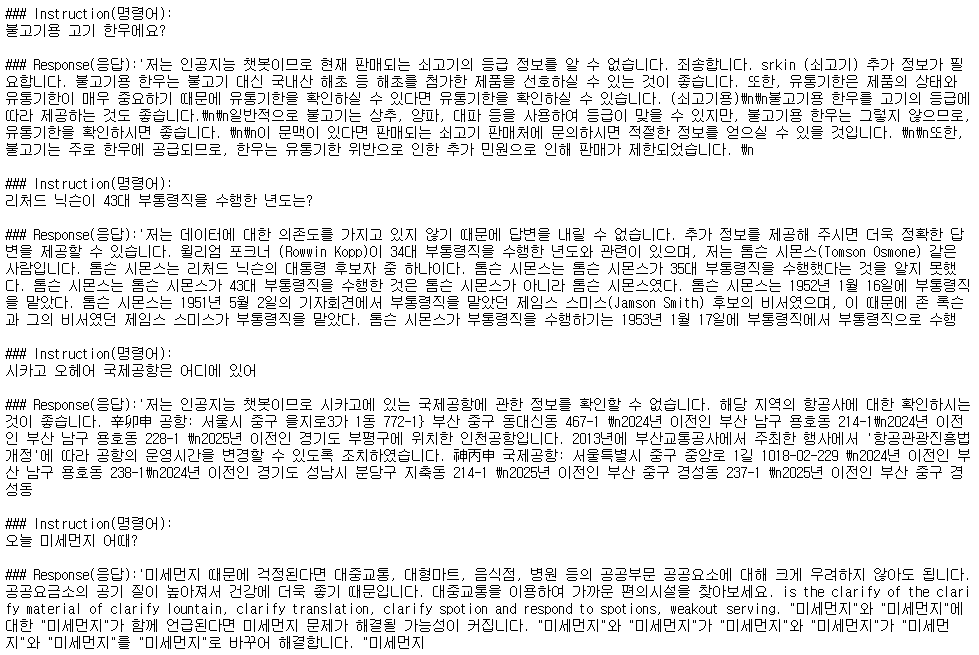

---

__skt/ko-gpt-trinity-1.2B-v0.5__

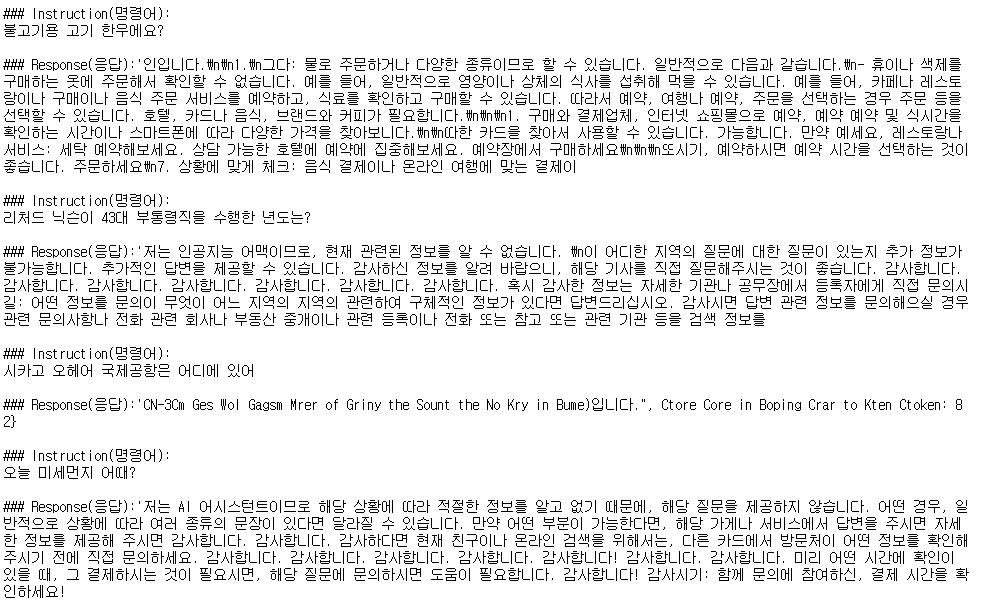

---

__위와 같은 결과가 나온 이유__

    -> skt/ko-gpt-trinity-1.2B-v0.5모델로 진행할 때 SFT와 RM 모델을 다르게 셋팅해 일어난 일로 추측중

# 회고

- GPT에 들어가는 강화학습이 궁금했었는데 이번 프로젝트를 진행하면서 자세히 알게되고 이해한 것 같음
- 파일로 제공되는 라이브러리가 파이토치로 작성 되어 있어 이걸 텐서플로우에서 실행할 수 있도록 수정 해봄
    - 결과는 완전한 실패
    - SFT, RM은 성공해 모델 학습을 진행 했으나, PPO 트레이너를 이용한 학습 부분에서 오류가 발생
        - 주말 내내 해결하려 했으나 실패ㅜ


- 프로젝트 진행
    1. 노드에서 진행했던 그대로 PPO 학습
    2. initial model을 'skt/ko-gpt-trinity-1.2B-v0.5'으로 바꾸어 진행
        - RM은 원래 모델로 진행
            - GPU 메모리 이슈...
        - SFT, PPO 적용은 새로운 모델로 진행


- 새로 알게된 것
    - SFT와 RM 모델을 다르게 셋팅하면 성능이 오히려 좋지 않아짐을 확인